# Linear Regression from Scratch — 2 Features
We’re going to build a simple **linear regression model** — nothing fancy, just NumPy, two input features, and one label.

- We’ll see how a model learns to fit data by **adjusting weights** to reduce error.  
- And by coding it ourselves, we’ll actually **see the math in action**.

Here’s the plan:
- Make some **fake but realistic** data (two features, one label).  
- Write a model that predicts the label from the features.  
- Use a loss function to see how bad the predictions are.  
- Use **gradient descent** to update the model and make it better step by step.

By the end, we’ll have a model that can find the right line (or in this case, the right plane) that fits the data. 


## The Model We’re Trying to Learn

**Synthetic data rule:**

$$
y = 3.5\,x_1 - 2.0\,x_2 + 4.0 + \varepsilon
$$

where:
- $x_1, x_2$ are the two input features,
- $w_1=3.5$ and $w_2=-2.0$ are the (unknown) **weights** we want to learn,
- $b=4.0$ is the **bias** (intercept),
- $\varepsilon$ is small random **noise**.

Our goal is to start with random guesses for $w_1, w_2,$ and $b$, then update them step by step so the model predicts $y$ as accurately as possible.


In [4]:
# Let's generate the synthetic data

import numpy as np

# Reproducibility
np.random.seed(42)

# Number of data points
n_samples = 1000

# Generate two input features between 0 and 10
X = np.random.rand(n_samples, 2) * 10  # shape: (200, 2)
print(X.shape[1])
# True weights and bias (the "ground truth" we're trying to learn)
true_w = np.array([3.5, -2.0]).reshape(2, 1) 
# true_w needs to be in (2, 1) shape since X dot true_w would be (200, 2) dot (2, 1)
true_b = 4.0

# Add some Gaussian noise for realism
noise = np.random.randn(n_samples).reshape(n_samples, 1) * 2  # stddev ~2

# Generate labels: y = 3.5 * x1 - 2.0 * x2 + 4.0 + noise
y = X @ true_w + true_b + noise  # shape: (200, 1)

# Peek at the first few rows
print("First 5 feature rows:\n", X[:5])
print("\nFirst 5 labels:\n", y[:5,:])


2
First 5 feature rows:
 [[3.74540119 9.50714306]
 [7.31993942 5.98658484]
 [1.5601864  1.5599452 ]
 [0.58083612 8.66176146]
 [6.01115012 7.08072578]]

First 5 labels:
 [[ -3.66134714]
 [ 15.99285757]
 [  5.88780422]
 [-10.55586548]
 [ 12.70474311]]


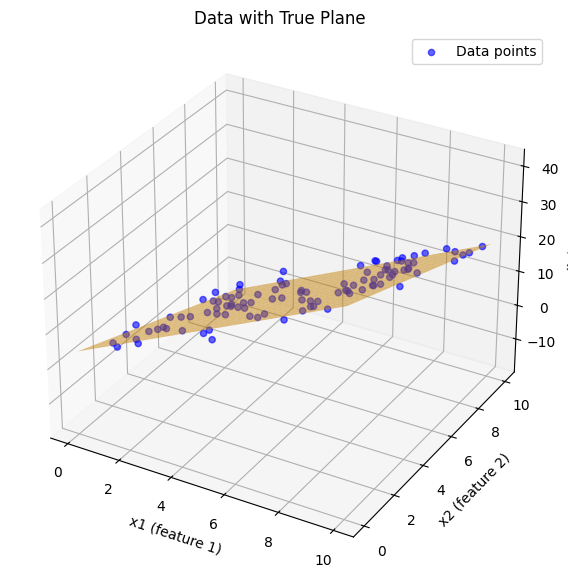

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_plane(X, y, w1, w2, b, title="Data with Plane", sample=100, grid_n=20):
    """
    Plot sampled data points with a plane defined by w1, w2, and b.
    X: (N,2) feature matrix
    y: (N,1) labels
    w1, w2, b: floats for plane coefficients
    title: plot title
    sample: how many random points to scatter for clarity
    grid_n: grid resolution for surface plot
    """
    # sample a subset of points for clarity
    idx = np.random.choice(X.shape[0], size=min(sample, X.shape[0]), replace=False)
    X_sample, y_sample = X[idx], y[idx]

    # grid for plane
    x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_n)
    x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_n)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
    Y_grid = w1 * X1_grid + w2 * X2_grid + b

    # plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_sample[:, 0], X_sample[:, 1], y_sample[:, 0], color="blue", alpha=0.6, label="Data points")
    ax.plot_surface(X1_grid, X2_grid, Y_grid, color="orange", alpha=0.5, edgecolor="none")
    ax.set_xlabel("x1 (feature 1)")
    ax.set_ylabel("x2 (feature 2)")
    ax.set_zlabel("y (label)")
    ax.set_title(title)
    plt.legend()
    plt.show()

# ---- Plot with the true plane ----
plot_plane(
    X, y,
    w1=3.5, w2=-2.0, b=4.0,
    title="Data with True Plane",
    sample=100
)


## Forward Pass: Making Predictions

To start, let's define our `predict` function. This takes:
- `X` (the feature matrix)
- `W` (the weights)
- `b` (the bias)

and returns the predicted values $\hat{y}$.


In [ ]:
def predict(X, W, b):
    return X @ W + b


## Augmenting the Feature Matrix (Bias as a Weight)

To simplify things, we'll include the bias directly in the weight vector. That means:
- Add a column of ones to `X` (creating `X_aug`).
- Stack the bias as the last entry in `W` so `W = [w_1, w_2, w_b]`.


In [6]:
import numpy as np
X_aug = np.hstack([X, np.ones((X.shape[0], 1))])
print('Shape of augmented X:', X_aug.shape)
print(X_aug[:5, :])


Shape of augmented X: (1000, 3)
[[3.74540119 9.50714306 1.        ]
 [7.31993942 5.98658484 1.        ]
 [1.5601864  1.5599452  1.        ]
 [0.58083612 8.66176146 1.        ]
 [6.01115012 7.08072578 1.        ]]


### Simpler predict function


In [12]:
# Now that we have augmented data, our predict function won't need bias and adding that bias
# It becomes a simple dot product
def predict(X, W):
    return X @ W

## Random Initial Weights

Let's start with a random guess for the weights (including the bias) and see what predictions we get.


In [7]:
rng = np.random.default_rng(0)
W_random = rng.normal(scale=0.1, size=(X_aug.shape[1], 1))  # (3,1): w1, w2, bias
print('Random weights (w1, w2, b):', W_random.T)

y_hat = X_aug @ W_random
print('First 5 predicted y values:', y_hat[:5].T)
print('First 5 actual y values:', y[:5].T)


Random weights (w1, w2, b): [[ 0.01257302 -0.01321049  0.06404227]]
First 5 predicted y values: [[-0.01446071  0.07699033  0.06305089 -0.04308095  0.04608076]]
First 5 actual y values: [[ -3.66134714  15.99285757   5.88780422 -10.55586548  12.70474311]]


In [8]:
# Now let's define a loss function - something that measures how bad we did on our predictions
# mean squared loss - diff between the predicted and actual, square that, average over all the data points
def mse_loss(y_pred, y_true):
    diff = y_pred - y_true                   # (N,1)
    return float((diff**2).mean())

loss = mse_loss(y_hat, y)
print(loss)

263.4258487934308


## Minimizing the Loss

Now we need to minimize the loss with respect to the parameters ($W$).

In other words, we want to find the set of weights ($W$) that makes our predictions ($\hat{y}$)
as close as possible to the actual labels ($y$).

The closer $\hat{y}$ is to $y$, the lower the loss (the mean squared error, or **MSE**).


### The Game Plan

Here’s the step-by-step plan for gradient descent:

1. Make a prediction ($\hat{y}$) with the current weights ($W$).
2. See how far off we are by looking at the loss.
3. Use the "gradient trick":
   - The gradient tells us the direction in which the loss would **increase** the fastest.
   - So, to **minimize** the loss, we nudge the weights in the **opposite** direction of the gradient.
4. Repeat this process many times until the loss stops decreasing(stays fairly flat, and hopefully low with each new iteration)

This nudging process is what we call **gradient descent**.


### From Concept to Math

Alright, now that we know what gradient descent is doing conceptually,
let's figure out how to actually **calculate the gradient** for our loss function.

Our loss is the mean squared error (MSE):

$$
\text{loss} = \frac{\sum (\hat{y} - y)^2}{N}
$$

At first glance, this might feel intimidating — there’s a sum, there’s a square...
how the heck do you take a derivative of that?

Here’s the trick:
- The sum just means we add up the same calculation for every sample.
- So we can focus on one sample first and generalize later.


### Focus on a Single Sample

For a single data point, the loss looks like this:

$$
\text{loss} = (\hat{y} - y)^2
$$

And we know that the prediction is computed as:

$$
\hat{y} = W \cdot X
$$

So, written in terms of $W$, our loss for that single sample is:

$$
\text{loss} = (W \cdot X - y)^2
$$

Important:
- $X$ here is the **feature vector** for that sample — it's a constant.
- The only thing that changes is $W$, so that’s what we differentiate with respect to.


### Taking the Derivative Step-by-Step

Let’s break this down slowly:

1. **Power rule:** the derivative of $u^2$ is $2u$
$$
2 \cdot (W \cdot X - y)
$$

2. **Chain rule:** the derivative of $(W \cdot X - y)$ with respect to $W$ is just $X$
$$
2 \cdot (W \cdot X - y) \cdot X
$$


### The Gradient for One Sample

Wild, right? The gradient of the loss for a single data point is simply:

$$
\nabla_W = 2 \cdot (\hat{y} - y) \cdot X
$$


### Updating the Weights

Now we use that gradient in our update rule:

$$
W = W - \eta \cdot \nabla_W
$$

Where:
- $W$ is the current weights vector
- $\eta$ (the **learning rate**) is just a fraction that controls how big our step is


### Why the Minus Sign

Because the gradient points in the direction of **greatest increase** of the loss.  
To minimize the loss, we need to move in the **opposite direction**.


### About the Learning Rate

- If $\eta$ is **too big** → we risk jumping past the minimum and bouncing around.
- If $\eta$ is **too small** → we crawl really slowly toward the minimum.


### Simplifying the Update Rule

Notice the factor of 2? It’s just a scale multiplier.  
We don’t really need it, because we can control the step size using the learning rate.

So, simplifying:

$$
W = W - \eta \cdot (\hat{y} - y) \cdot X
$$


### Intuition

- If $\hat{y}$ is **larger** than $y$ (positive $(\hat{y} - y)$):  
  We move $W$ in the opposite direction to bring predictions **down**.  
  Smaller $W$ → smaller $\hat{y}$ next time.

- If $\hat{y}$ is **smaller** than $y$ (negative $(\hat{y} - y)$):  
  We move $W$ upward. Negative × negative = positive.  
  Larger $W$ → larger $\hat{y}$ next time.


## Training Loop: Full-Batch Gradient Descent

Now that we understand the math, let’s put it all together into a simple **training loop**.

Here’s what we’ll do:

1. **Set up**  
   - Start with random weights $W$ (including the bias term).  
   - Pick a learning rate $\eta$ (small enough for stability, big enough for progress).  
   - Choose how many iterations (epochs) to train (e.g., 500 or 1,000).

2. **Loop for each iteration**  
   - **Predict** $\hat{y}$ for *all* data points using the current weights.  
   - **Calculate the loss** (mean squared error) across the entire dataset.  
   - **Log the loss** so we can watch it decrease over time (and plot it later).  
   - **Compute the gradient** of the loss with respect to $W$.  
   - **Update the weights** by stepping opposite the gradient:
     $$
     W \leftarrow W - \eta \cdot \nabla_W
     $$

3. **Repeat**  
   - Do this for the fixed number of iterations you selected.  
   - In this example, we won’t stop early — we’ll train for the full number of iterations and then check how the loss has decreased.


In [47]:
# Start with random weights W (including the bias term). 
import numpy as np
rng = np.random.default_rng(0)
W = rng.normal(scale=0.1, size=(X_aug.shape[1], 1))  # (3,1): w1, w2, bias
print("W.shape():", W.shape)
print('Random weights (w1, w2, b):', W.T)


# Pick a Learning Rate
learning_rate = 0.025

# Pick num of epoch(epoch is going through all the data points once)
num_epochs = 2000

gradient_magnitude = np.inf
gradient_magnitude_convergence_threshold = 1e-3

for epoch in range(num_epochs):
    y_pred = predict(X_aug, W)
    # assert each data point got a prediction
    assert y_pred.shape[0] == X_aug.shape[0]
    
    # calculate mse
    # for each data point subtract the label from the prediction, square this difference
    # average these squared differences across the entire dataset
    loss = mse_loss(y_pred, y)
    
    # calculate the gradient
    gradients_for_all_data_points = (y_pred - y) * X_aug
    
    # this should give us a shape of num_samples * num_features
    # which are the partial derivatives for each data point for each dimension(feature)
    
    # now that we have the gradients for all data points
    # we average those, and we should end up with a 1 x 3 vector which is the gradient for the entire dataset
    # the following is really this part: ((y_hat - y) * X)/num_data_points
    mean_gradient = np.mean(gradients_for_all_data_points, axis=0, keepdims=True)
    
    # now we adjust the weights based on the gradient and learning rate
    W = W - learning_rate * mean_gradient.T
    # we have to transpose the mean_gradient, because it is in a shape of 1 x 3, but we initialized our W to be 3 x 1
    
    # see if the gradient is tiny - if it is tiny, then the update to W would also be tiny and possibly insignificant 
    # if it is under a certain threshold, call it "mission accomplished"
    gradient_magnitude = np.linalg.norm(mean_gradient)
        
    # when the loss drops pretty close to 0, we should see weights be 3.5 (w1), -2 (w2) and 4 (w0 - bias)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:4d} | loss={loss:.6f} | gradient_magnitude={gradient_magnitude:.6e} | W.T={W.T}")

    if gradient_magnitude <= gradient_magnitude_convergence_threshold:
        print(f"Converged at epoch {epoch+1}: loss={loss:.6f}, gradient_magnitude={gradient_magnitude:.3e}, W.T={W.T}")
        break
    

W.shape(): (3, 1)
Random weights (w1, w2, b): [[ 0.01257302 -0.01321049  0.06404227]]
Epoch  100 | loss=4.966655 | gradient_magnitude=4.077144e-01 | W.T=[[ 3.71558885 -1.77682663  1.43400918]]
Epoch  200 | loss=4.373759 | gradient_magnitude=2.840940e-01 | W.T=[[ 3.64771023 -1.85424435  2.28171161]]
Epoch  300 | loss=4.085893 | gradient_magnitude=1.979558e-01 | W.T=[[ 3.60041263 -1.90818877  2.87238787]]
Epoch  400 | loss=3.946127 | gradient_magnitude=1.379349e-01 | W.T=[[ 3.56745582 -1.94577706  3.28396913]]
Epoch  500 | loss=3.878267 | gradient_magnitude=9.611261e-02 | W.T=[[ 3.54449162 -1.97196846  3.5707576 ]]
Epoch  600 | loss=3.845319 | gradient_magnitude=6.697095e-02 | W.T=[[ 3.52849024 -1.99021854  3.77059086]]
Epoch  700 | loss=3.829322 | gradient_magnitude=4.666514e-02 | W.T=[[ 3.51734053 -2.00293513  3.90983402]]
Epoch  800 | loss=3.821555 | gradient_magnitude=3.251611e-02 | W.T=[[ 3.50957146 -2.01179601  4.00685819]]
Epoch  900 | loss=3.817784 | gradient_magnitude=2.265712e-

### Let's see what we have learned


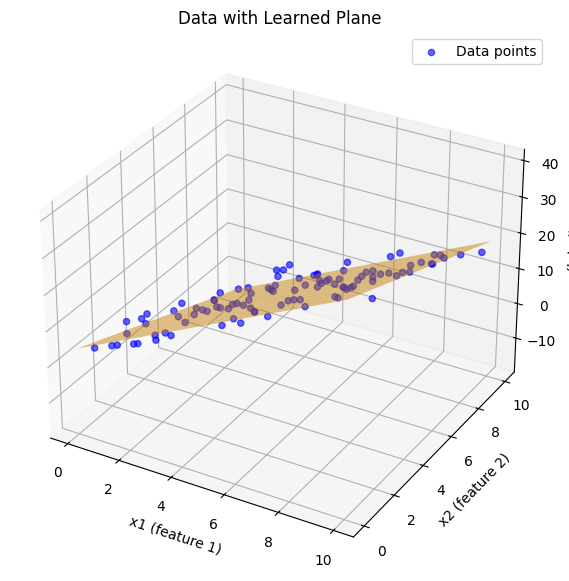

In [43]:
# ---- Plot with the learned plane ----
plot_plane(
    X, y,
    w1=W[0, 0], w2=W[1, 0], b=W[2, 0],
    title="Data with Learned Plane",
    sample=100
)

### And Let's just remember what the tru plane was:


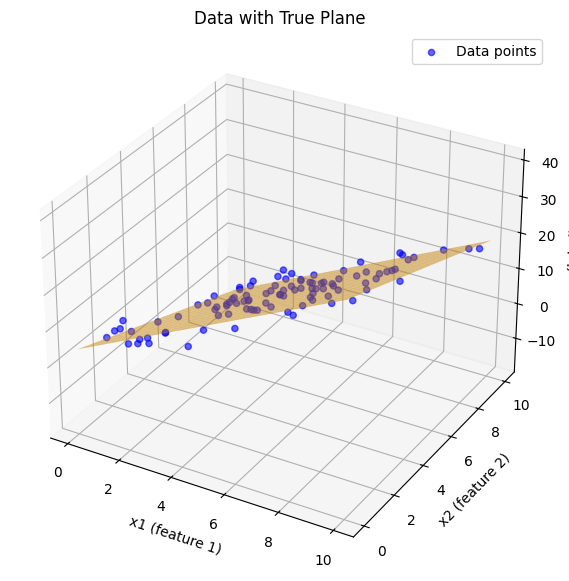

In [44]:
# ---- Plot with the true plane ----
plot_plane(
    X, y,
    w1=3.5, w2=-2.0, b=4.0,
    title="Data with True Plane",
    sample=100
)

### Pretty close  
#### So we call it mission accomplished!  
#### Though, let's do mini-batches so it is more educational  

In the code above, we used NumPy’s vectorization to compute the gradient and loss for the **entire dataset at once**.  
This is fine for our small synthetic dataset, but it doesn’t scale well if your dataset has hundreds of thousands or millions of records.  

- **Memory:** For huge datasets, you simply can’t fit everything in memory at once.  
- **Computation:** Even if you *can* fit it, computing the full gradient every time is expensive and slow.  

---

One extreme alternative is **stochastic gradient descent (SGD)**:  
- You take **one data point at a time**, compute its loss and gradient, and update the weights immediately.  
- This uses almost no memory (just a single data point at a time).  
- But it’s very **noisy** — each update reflects just one data point, which usually isn’t representative of the whole dataset.  
- The result: weight updates jump all over the place and training takes a long time to settle.  

---

#### Mini-Batching  
As with most things in life, the sweet spot is **somewhere in between**.  
- We randomly sample a **small sub-dataset (mini-batch)** from the full dataset.  
- Compute the **average loss and gradient** for that mini-batch.  
- Update the weights using this mini-batch gradient.  

This way:  
- It’s much faster and more memory-efficient than using the full dataset.  
- It’s more stable and representative than using just one point at a time.  

Alright, let’s have GPT cook up some code to show how mini-batching works.


In [79]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

# init (same as before)
rng = np.random.default_rng(0)
W = rng.normal(scale=0.1, size=(X_aug.shape[1], 1))  # (3,1): w1, w2, bias
print("W.shape():", W.shape)
print('Random weights (w1, w2, b):', W.T)

learning_rate = 0.0005
num_epochs = 2000
batch_size = 32  # common defaults: 16, 32, 64

grad_norm_threshold = 0.03

number_records = X_aug.shape[0]

for epoch in range(num_epochs):
    # 1) shuffle indices once per epoch
    perm = rng.permutation(number_records)

    # 2) iterate over mini-batches
    batch = 1
    for start in range(0, number_records, batch_size):
        end = start + batch_size
        idx = perm[start:end]

        Xb = X_aug[idx]       # (B, D)
        yb = y[idx]           # (B, 1)

        # forward on batch
        y_pred_b = predict(Xb, W)

        # batch gradient (same form as your full-batch, just over batch)
        # mean over rows -> (1, D)
        mean_grad_b = np.mean((y_pred_b - yb) * Xb, axis=0, keepdims=True)

        # update
        W -= learning_rate * mean_grad_b.T  # shape match: (D,1)

    # 3) end-of-epoch: compute full-batch loss + grad norm for logging/early stop
    y_pred_full = predict(X_aug, W)
    loss_full = mse_loss(y_pred_full, y)
    full_grad = np.mean((y_pred_full - y) * X_aug, axis=0, keepdims=True)  # (1, D)
    grad_norm = np.linalg.norm(full_grad)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:4d} | loss={loss_full} | grad_norm={grad_norm} | W.T={W.T}")

    if grad_norm <= grad_norm_threshold:
        print(f"Converged at epoch {epoch+1}: loss={loss_full}, grad_norm={grad_norm}, W.T={W.T}")
        break


W.shape(): (3, 1)
Random weights (w1, w2, b): [[ 0.0126 -0.0132  0.064 ]]
Epoch   10 | loss=14.57322542086148 | grad_norm=8.530889964001725 | W.T=[[ 3.0939 -0.9711  0.3161]]
Epoch   20 | loss=6.537035488741026 | grad_norm=2.2800054505230207 | W.T=[[ 3.614  -1.4995  0.3999]]
Epoch   30 | loss=5.902510137229812 | grad_norm=0.7911371218840209 | W.T=[[ 3.7465 -1.6429  0.4866]]
Epoch   40 | loss=5.776125494523993 | grad_norm=0.5577543223460718 | W.T=[[ 3.7709 -1.6864  0.5714]]
Epoch   50 | loss=5.686659503864118 | grad_norm=0.5855429848012904 | W.T=[[ 3.7707 -1.7048  0.6541]]
Epoch   60 | loss=5.602381584072463 | grad_norm=0.5430979481887991 | W.T=[[ 3.7699 -1.7159  0.7348]]
Epoch   70 | loss=5.521854703807677 | grad_norm=0.5158182152496336 | W.T=[[ 3.7644 -1.7163  0.8149]]
Epoch   80 | loss=5.44600150816235 | grad_norm=0.572006886099465 | W.T=[[ 3.7625 -1.7237  0.8932]]
Epoch   90 | loss=5.371911763153869 | grad_norm=0.5292372723280823 | W.T=[[ 3.7518 -1.7388  0.9682]]
Epoch  100 | loss=5.